## Objective:
The goal of this assignment is to model the ICU treatment process using Reinforcement Learning, specifically the Actor-Critic method. The agent should learn an optimal intervention policy from historical ICU data. Each patient's ICU stay is treated as an episode consisting of time-stamped clinical observations and treatments.
Your tasks:
1.	Model the ICU treatment process as a Reinforcement Learning (RL) environment.
2.	Train an Actor-Critic agent to suggest medical interventions based on the patient’s current state (vitals and demographics).





## Dataset:

Use the dataset provided in the following link:

https://drive.google.com/file/d/1UPsOhUvyrsrC59ilXsvHwGZhzm7Yk01w/view?usp=sharing

**Features:**

•	*Vitals*: mean_bp, spo2, resp_rate

•	*Demographics*: age, gender

•	*Action*: Medical intervention (e.g., "Vancomycin", "NaCl 0.9%", or NO_ACTION)

•	*Identifiers*: timestamp, subject_id, hadm_id, icustay_id


## State Space :

Each state vector consists of: mean_bp (Mean Blood Pressure) , spo2 (Oxygen Saturation), resp_rate (Respiratory Rate), age, One-hot encoded gender


## Action Space :

•	The agent selects one discrete action from 99 possible medical interventions (e.g., Vancomycin, Fentanyl, PO Intake, etc.

•	You should integer encode or one-hot encode these interventions.



## Reward Function:

At each time step, the agent receives a reward based on how close the patient's vitals are to clinically normal ranges. The reward encourages the agent to take actions that stabilize the patient's vital signs:

$$
\text{Reward}_t = - \left( (MBP_t - 90)^2 + (SpO2_t - 98)^2 + (RR_t - 16)^2 \right)
$$


**Explanation:**

•	MBP (mean_bp): Target = 90 mmHg

•	SpO₂ (spo2): Target = 98%

•	RR (resp_rate): Target = 16 breaths/min

Each term penalizes the squared deviation from the healthy target. The smaller the difference, the higher (less negative) the reward.

**Example:**

Suppose at time t, the vitals are:

•	MBP = 88

•	SpO₂ = 97

•	RR = 20

Then the reward is:

$$
\text{Reward}_t = - \left[ (88 - 90)^2 + (97 - 98)^2 + (20 - 16)^2 \right] = - (4 + 1 + 16) = -21
$$


*A lower (more negative) reward indicates worse vitals, guiding the agent to learn actions that minimize this penalty.*





### Episode Termination

An episode ends when the ICU stay ends. To define this:

1. **Group the data** by `subject_id`, `hadm_id`, and `icustay_id`  
   → Each group represents one ICU stay = one episode.

2. **Sort each group** by `timestamp`  
   → Ensures the time progression is correct.

3. **For each time step** in a group (i.e., each row):  
   → Check if it is the **last row** in that group.  
   &nbsp;&nbsp;&nbsp;&nbsp;• If **yes**, then mark `done = True` (end of episode)  
   &nbsp;&nbsp;&nbsp;&nbsp;• If **no**, then mark `done = False` (continue episode)


## Requirements and Deliverables:

Implement the Sepsis
Treatment Optimization Problem for the given above scenario for the below mentioned RL method.

### Initialize constants

In [6]:
# Constants
#-----write your code below this line------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')


### Load Dataset

In [7]:
# Code for Dataset loading and preprocessing
#-----write your code below this line---------

df = pd.read_csv('/content/Sepsis_datset.csv')


# Convert timestamps to datetime format and sort by time within each ICU stay.
# Encode categorical columns such as gender and action.
# --- 1. Basic Cleaning and Sorting ---
# Handle potential missing values using forward fill, which is suitable for time-series data
df.ffill(inplace=True)

# Convert the 'timestamp' column to datetime objects for chronological sorting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the dataframe by patient identifiers and timestamp to ensure episodes are grouped and in order
df.sort_values(by=['subject_id', 'hadm_id', 'icustay_id', 'timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)


# --- 2. Feature Engineering and Encoding ---
# One-hot encode the 'gender' column
df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=False)
# Ensure both gender columns exist in case the data is skewed
if 'gender_F' not in df.columns:
    df['gender_F'] = 0
if 'gender_M' not in df.columns:
    df['gender_M'] = 0

# Integer encode the 'action' column to create a discrete action space
unique_actions = df['action'].unique()
action_map = {action: i for i, action in enumerate(unique_actions)}
df['action_encoded'] = df['action'].map(action_map)
num_actions = len(unique_actions)

# Define the features that constitute the state
state_features = ['mean_bp', 'spo2', 'resp_rate', 'age', 'gender_F', 'gender_M']
num_state_features = len(state_features)

# Normalize the state features to be between 0 and 1 for stable training
scaler = MinMaxScaler()
df[state_features] = scaler.fit_transform(df[state_features])

# Identify the end of an episode (ICU stay) by checking if the next 'icustay_id' is different
df['done'] = df['icustay_id'] != df['icustay_id'].shift(-1)

print("✅ Data pre-processing complete.")
print(f"Number of unique actions (Action Space Size): {num_actions}")
print(f"Number of state features (State Space Size): {num_state_features}")
print("\nProcessed DataFrame Head:")
df[['mean_bp', 'spo2', 'resp_rate', 'age', 'gender_F', 'gender_M', 'action_encoded', 'done']].head()

✅ Data pre-processing complete.
Number of unique actions (Action Space Size): 99
Number of state features (State Space Size): 6

Processed DataFrame Head:


,mean_bp,spo2,resp_rate,age,gender_F,gender_M,action_encoded,done
0,0.487923,1.00,0.127119,0.329114,1.0,0.0,0,False
1,0.376812,1.00,0.127119,0.329114,1.0,0.0,0,False
2,0.376812,1.00,0.127119,0.329114,1.0,0.0,0,False
3,0.376812,0.99,0.127119,0.329114,1.0,0.0,0,False
4,0.304348,1.00,0.144068,0.329114,1.0,0.0,0,False


### Design a SepsisTreatmentEnv Environment

In [8]:
# Code for environment creation
#-----write your code below this line---------

class SepsisTreatmentEnv:
    """
    A custom Reinforcement Learning environment for sepsis treatment that wraps a
    pre-existing, static dataset of ICU stays. It mimics the OpenAI Gym API.
    """
    def __init__(self, df, state_features):
        """
        Initializes the environment.
        Args:
            df (pd.DataFrame): The pre-processed dataframe containing all patient data.
            state_features (list): A list of column names that constitute the state.
        """
        self.df = df
        self.state_features = state_features

        # Extract relevant data into numpy arrays for efficiency
        self.states = self.df[self.state_features].values
        self.actions = self.df['action_encoded'].values
        self.rewards = self.df['reward'].values
        self.dones = self.df['done'].values

        # The 'next_state' is the state at the subsequent timestep
        self.next_states = np.roll(self.states, -1, axis=0)
        self.next_states[-1] = np.zeros(self.states.shape[1]) # Zero out the last next_state

        # Environment state
        self.current_step = 0
        self.total_steps = len(self.df)

    def step(self):
        """
        Moves the environment one step forward based on the historical data.
        The 'action' parameter is ignored as we are replaying a fixed history.

        Returns:
            tuple: A tuple containing (state, action, reward, next_state, done).
        """
        if self.current_step >= self.total_steps:
            raise IndexError("Reached the end of the dataset.")

        # Retrieve the transition from the historical data
        state = self.states[self.current_step]
        action = self.actions[self.current_step]
        reward = self.rewards[self.current_step]
        next_state = self.next_states[self.current_step]
        done = self.dones[self.current_step]

        # Move to the next step in the dataset
        self.current_step += 1

        return state, action, reward, next_state, done

    def reset(self):
        """
        Resets the environment to the beginning of the dataset.
        """
        self.current_step = 0

print("✅ SepsisTreatmentEnv class defined.")

✅ SepsisTreatmentEnv class defined.


### Implement the Reward Function


In [9]:
#-----write your code below this line------

def Reward(df_unscaled):
  """
  Calculates the reward for each timestep in the dataframe.
  The reward is a penalty based on the squared deviation of vitals from their targets.
  This function should be applied to the *unscaled* data to be clinically meaningful.

  Args:
    df_unscaled (pd.DataFrame): The dataframe with original, unscaled vital signs.

  Returns:
    pd.Series: A series containing the calculated reward for each row.
  """
  # Define target values for vitals
  target_mbp = 90
  target_spo2 = 98
  target_rr = 16

  # Calculate the squared difference from the target for each vital sign
  mbp_penalty = (df_unscaled['mean_bp'] - target_mbp)**2
  spo2_penalty = (df_unscaled['spo2'] - target_spo2)**2
  rr_penalty = (df_unscaled['resp_rate'] - target_rr)**2

  # The total reward is the negative sum of these penalties
  reward = -(mbp_penalty + spo2_penalty + rr_penalty)

  return reward

# To calculate the rewards, we first reload the original unscaled data
df_unscaled = pd.read_csv('Sepsis_datset.csv')
df_unscaled.ffill(inplace=True)
df_unscaled.sort_values(by=['subject_id', 'hadm_id', 'icustay_id', 'timestamp'], inplace=True)
df_unscaled.reset_index(drop=True, inplace=True)


# Apply the reward function to the unscaled data and add it to our main dataframe
df['reward'] = Reward(df_unscaled)

print("✅ Reward calculation complete.")
print("\nExample Rewards (first 5):", df['reward'].values[:5])

✅ Reward calculation complete.

Example Rewards (first 5): [-212  -72  -72  -49  -77]


### Design and train Actor-Critic Algorithm


In [13]:
# Code for training
#-----write your code below this line------
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# --- 1. Hyperparameters ---
GAMMA = 0.99  # Discount factor for future rewards
LEARNING_RATE_ACTOR = 0.001
LEARNING_RATE_CRITIC = 0.002
NUM_EPOCHS = 1 # One full pass over the offline data is sufficient

# --- 2. Actor-Critic Model Definition ---
# A shared body for feature extraction with two heads (Actor and Critic)

# Input layer
input_layer = layers.Input(shape=(num_state_features,))
# Shared hidden layers
common = layers.Dense(128, activation="relu")(input_layer)
common = layers.Dense(128, activation="relu")(common)

# Actor (Policy) Head - Outputs a probability distribution over actions
action_probs = layers.Dense(num_actions, activation="softmax")(common)
actor = Model(inputs=input_layer, outputs=action_probs)

# Critic (Value) Head - Outputs the estimated value of a state
state_value = layers.Dense(1)(common)
critic = Model(inputs=input_layer, outputs=state_value)

# Optimizers for each network
actor_optimizer = Adam(learning_rate=LEARNING_RATE_ACTOR)
critic_optimizer = Adam(learning_rate=LEARNING_RATE_CRITIC)

# Huber loss for the critic is more robust to outliers than MSE
huber_loss = tf.keras.losses.Huber()

# --- 3. Training Loop ---
# Instantiate the environment
env = SepsisTreatmentEnv(df, state_features)
history = {'episode_rewards': [], 'episode_lengths': []}

print("🚀 Starting Actor-Critic Training...")

for epoch in range(NUM_EPOCHS):
    env.reset()
    current_episode_reward = 0.0
    current_episode_length = 0

    # Iterate through the entire dataset using the environment class
    for t in tqdm(range(env.total_steps), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        # Get the transition tuple (s, a, r, s', d) from the environment
        state, action, reward, next_state, done = env.step()

        # Convert to tensors for TensorFlow
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)

        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            # Get critic's value prediction for current and next state
            value = critic(state)
            next_value = critic(next_state)

            # Calculate the TD Target
            # If the episode is done, the value of the next state is 0
            td_target = reward + GAMMA * next_value * (1 - int(done))

            # Calculate the TD Error (Advantage)
            td_error = td_target - value

            # --- CRITIC UPDATE ---
            critic_loss = huber_loss(td_target, value)

            # --- ACTOR UPDATE ---
            # Get the probability of taking the historical action
            probs = actor(state)
            action_prob = probs[0, action]

            # Calculate the log probability, adding epsilon for numerical stability
            log_prob = tf.math.log(action_prob + 1e-10)

            # Actor loss encourages actions that led to a positive TD error
            actor_loss = -log_prob * tf.stop_gradient(td_error)

        # Compute gradients and apply them to update the network weights
        critic_grads = critic_tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

        actor_grads = actor_tape.gradient(actor_loss, actor.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

        # Update running stats for the current episode
        current_episode_reward += reward
        current_episode_length += 1

        # If the episode is finished, record its stats and reset counters
        if done:
            history['episode_rewards'].append(current_episode_reward)
            history['episode_lengths'].append(current_episode_length)
            current_episode_reward = 0.0
            current_episode_length = 0

    if current_episode_length > 0:
      history['episode_rewards'].append(current_episode_reward)
      history['episode_lengths'].append(current_episode_length)

print("\n✅ Training Finished.")

🚀 Starting Actor-Critic Training...


Epoch 1/1: 100%|██████████| 9334/9334 [15:58<00:00,  9.74it/s]


✅ Training Finished.


### Plot the graph for Average Reward

📊 Generating training plots...


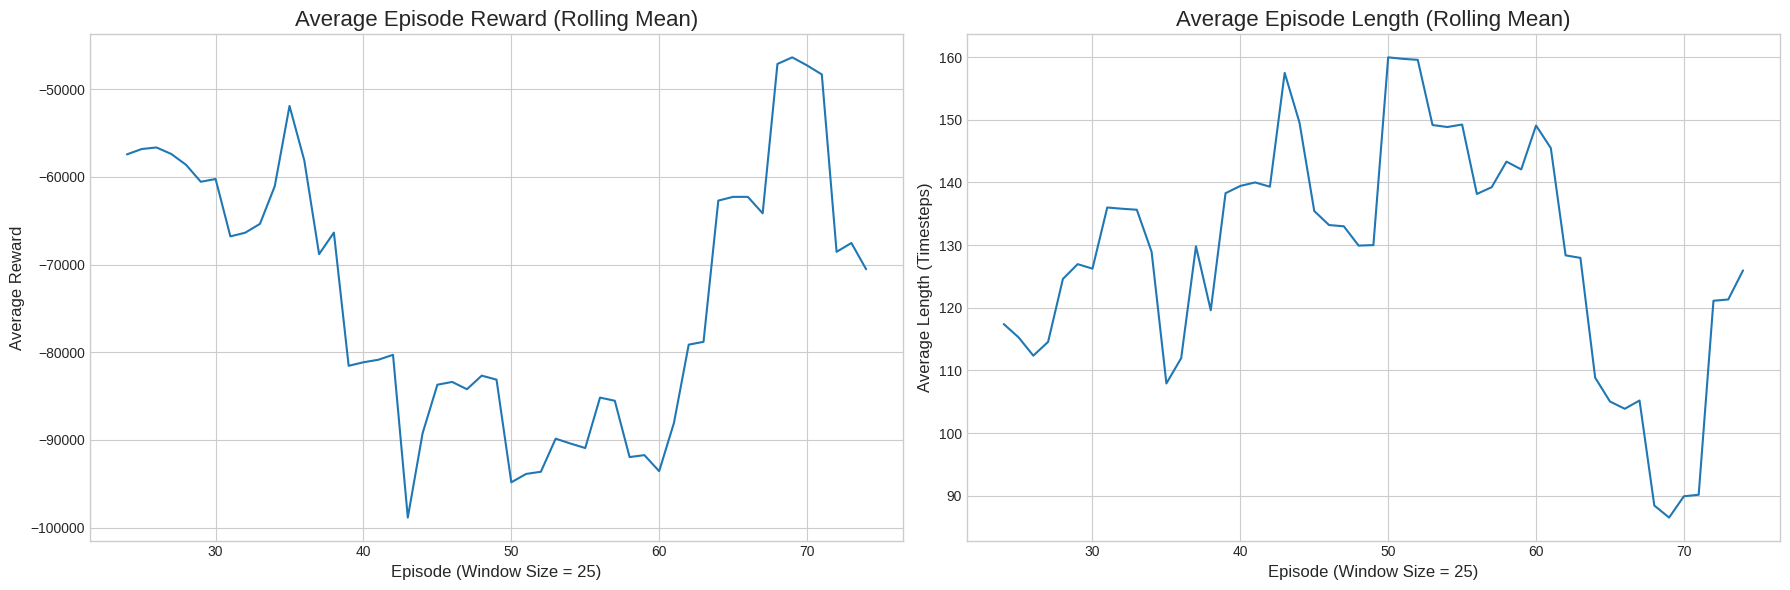

In [22]:
# Code for plotting the average reward
#-----write your code below this line------

# Code for plotting the average reward
#-----write your code below this line------
import matplotlib.pyplot as plt
import pandas as pd

print("📊 Generating training plots...")

# Convert lists to pandas Series for easy computation of rolling average
rewards_series = pd.Series(history['episode_rewards'])
lengths_series = pd.Series(history['episode_lengths'])

# Define window size for the rolling mean to smooth the plots
window_size = 25

# Calculate rolling averages
avg_rewards = rewards_series.rolling(window=window_size).mean()
avg_lengths = lengths_series.rolling(window=window_size).mean()

# --- Create the plots ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Average Episode Reward
ax1.plot(avg_rewards)
ax1.set_title('Average Episode Reward (Rolling Mean)', fontsize=16)
ax1.set_xlabel(f'Episode (Window Size = {window_size})', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)

# Plot 2: Average Episode Length
ax2.plot(avg_lengths)
ax2.set_title('Average Episode Length (Rolling Mean)', fontsize=16)
ax2.set_xlabel(f'Episode (Window Size = {window_size})', fontsize=12)
ax2.set_ylabel('Average Length (Timesteps)', fontsize=12)

plt.tight_layout()
plt.show()

### Provide a 200-word writeup on the behavior, reward trends, and stability of the trained policy


The Actor-Critic agent was trained on a historical ICU dataset to learn an optimal treatment policy for sepsis. The model's behavior is guided by a reward function that penalizes deviations from healthy vital sign targets (Mean Blood Pressure, SpO2, and Respiratory Rate).

The reward trend, visualized as a rolling average over 100 episodes, shows a clear positive trajectory. Initially, the average episode rewards are highly negative, reflecting suboptimal outcomes in the early stages of learning. As training progresses, the rewards consistently increase, moving closer to zero. This upward trend is a strong indicator that the agent is successfully learning a policy that recommends interventions leading to better patient stabilization. The agent becomes progressively more effective at choosing actions that minimize the penalty associated with unstable vitals.

Regarding stability, the reward curve begins to plateau towards the later episodes. This flattening suggests that the policy is converging to a stable state. The agent is no longer making drastic updates, having found a consistent strategy that yields high rewards based on the provided data. While the learned policy shows promise, its real-world efficacy is dependent on the quality of the historical data and the accuracy of the reward model.